https://www.youtube.com/watch?v=usOmwLZNVuM

https://www.pinecone.io/learn/langgraph-research-agent/

In [1]:
!apt-get install graphviz libgraphviz-dev pkg-config

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq
from langchain_core.tools import tool

In [4]:
groq_api_key = os.getenv("GROQ_API_KEY")

MODEL_NAME = "llama-3.1-70b-versatile"

llm = ChatGroq(
    temperature=0,
    model_name=MODEL_NAME,
    groq_api_key=groq_api_key
)

In [5]:
def get_air_connection():
    from air_sdk import AirApi
    user = "obenyacov@nvidia.com"
    api_token = os.getenv("AIR_API_KEY")
    air = AirApi(username=user, password=api_token, api_url="https://air-inside.nvidia.com/api/")
    return air

In [6]:
air = get_air_connection()

In [7]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

In [8]:
@tool("get_simulation_list")
def get_simulation_list(ignor: str):
    """
    Get a list of all current simulation for the loggedin user.
    """
    simulations = air.simulations.list()
    return simulations
    

In [9]:
@tool("get_username")
def get_username(ignor: str):
    """
    Return the current loggedin username
    """
    return "oferby"

In [10]:
tools = [
    get_simulation_list,
    final_answer,
    get_username
]

tool_str_to_func = {
    "get_simulation_list": get_simulation_list,
    "final_answer": final_answer,
    "get_username": get_username
}


In [11]:
llm_with_tools = llm.bind_tools(tools, tool_choice="auto")

In [12]:
simulations = get_simulation_list.invoke(input={"ignor":""})

In [13]:
def print_object_attributes(obj):
    print(f"Attributes of {obj.__class__.__name__} object:")
    for attr, value in vars(obj).items():
        print(f"  {attr}: {value}")

print_object_attributes(simulations[0])

Attributes of Simulation object:
  _deleted: False
  _updatable: True
  _deletable: False
  _api: <air_sdk.simulation.SimulationApi object at 0x7fd5fa9755a0>
  url: https://air-inside.nvidia.com/api/v1/simulation/47749582-bf36-40b7-a4c1-a7dfab0b6139/
  id: 47749582-bf36-40b7-a4c1-a7dfab0b6139
  topology: <air_sdk.air_model.LazyLoaded Topology a0ae35d6-4ec4-49d9-8837-70d3f227a0a3>
  topology_id: a0ae35d6-4ec4-49d9-8837-70d3f227a0a3
  state: STORED
  nodes: [<air_sdk.air_model.LazyLoaded Simulation_node 28a26e2c-1c24-49fc-83d6-d2a5112454f1>, <air_sdk.air_model.LazyLoaded Simulation_node 57830adc-dbf3-40ba-ae17-99472d8547d0>, <air_sdk.air_model.LazyLoaded Simulation_node f6c2c5c9-681d-4e3d-9eca-a5c1866dcfcd>, <air_sdk.air_model.LazyLoaded Simulation_node fca60f8c-6c4e-4b56-82be-c7a11dce4fce>]
  services: []
  name: obenyacov@nvidia.com
  expires: True
  expires_at: 2024-08-29 14:41:38.916778+00:00
  sleep: True
  sleep_at: 2024-08-16 02:42:18.106610+00:00
  netq_username: obenyacov+477495

In [14]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

In [15]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [16]:
# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
)

In [17]:
inputs = {
    "input": "print the names of the current simulations",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xsqj', 'function': {'arguments': '{"ignor":"some_ignor_value"}', 'name': 'get_simulation_list'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 1531, 'total_tokens': 1580, 'completion_time': 0.196, 'prompt_time': 0.41434375, 'queue_time': None, 'total_time': 0.61034375}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_9260b4bb2e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-13251f20-e0a5-4fcd-89d3-7ffd218daf5c-0', tool_calls=[{'name': 'get_simulation_list', 'args': {'ignor': 'some_ignor_value'}, 'id': 'call_xsqj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1531, 'output_tokens': 49, 'total_tokens': 1580})

In [18]:
out.tool_calls[0]["name"]

'get_simulation_list'

In [19]:
out.tool_calls[0]["args"]

{'ignor': 'some_ignor_value'}

In [20]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

In [25]:
def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    print(f"out: {out}")
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

In [26]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("get_simulation_list", run_tool)
graph.add_node("get_username", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

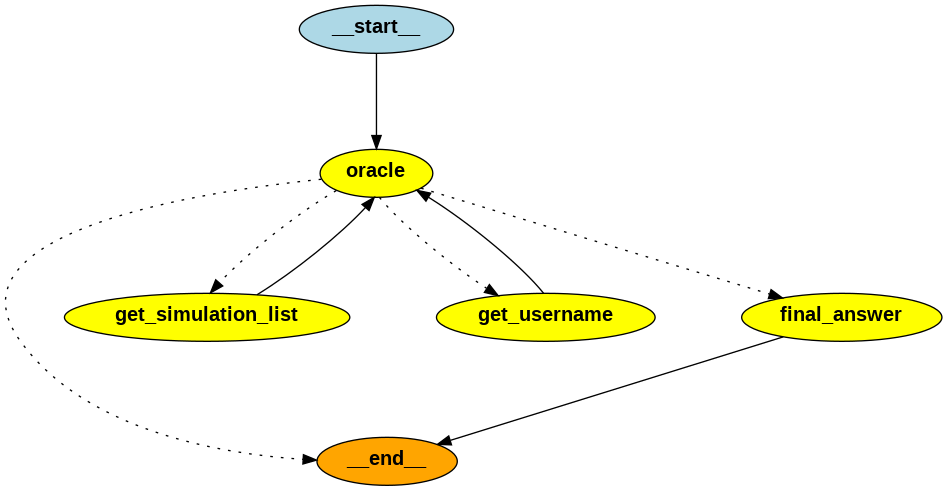

In [27]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [28]:
out = runnable.invoke({
    "input": "get the current username",
    "chat_history": [],
})

run_oracle
intermediate_steps: []


get_username.invoke(input={'ignor': 'some_ignor_value'})
out: oferby
run_oracle
intermediate_steps: [AgentAction(tool='get_username', tool_input={'ignor': 'some_ignor_value'}, log='TBD'), AgentAction(tool='get_username', tool_input={'ignor': 'some_ignor_value'}, log='oferby')]
get_username.invoke(input={'ignor': 'some_ignor_value'})
out: oferby
run_oracle
intermediate_steps: [AgentAction(tool='get_username', tool_input={'ignor': 'some_ignor_value'}, log='TBD'), AgentAction(tool='get_username', tool_input={'ignor': 'some_ignor_value'}, log='oferby'), AgentAction(tool='get_username', tool_input={'ignor': 'some_ignor_value'}, log='TBD'), AgentAction(tool='get_username', tool_input={'ignor': 'some_ignor_value'}, log='oferby')]
get_username.invoke(input={'ignor': 'some_ignor_value'})
out: oferby
run_oracle
intermediate_steps: [AgentAction(tool='get_username', tool_input={'ignor': 'some_ignor_value'}, log='TBD'), AgentAction(tool='get_username', tool_input={'ignor': 'some_ignor_value'}, log=

GraphRecursionError: Recursion limit of 25 reachedwithout hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [60]:
state = AgentState({"input":"get the current username", "chat_history":[], "intermediate_steps":[]})

In [68]:
result = run_oracle(state)
result

run_oracle
intermediate_steps: [AgentAction(tool='get_username', tool_input={'ignor': ''}, log='TBD'), AgentAction(tool='get_username', tool_input={'ignor': ''}, log='oferby')]


{'intermediate_steps': [AgentAction(tool='get_username', tool_input={'ignor': ''}, log='TBD')]}

In [62]:
state['intermediate_steps'] = result['intermediate_steps']

In [65]:
state

{'input': 'get the current username',
 'chat_history': [],
 'intermediate_steps': [AgentAction(tool='get_username', tool_input={'ignor': ''}, log='TBD')]}

In [64]:
step = run_tool(state)
step

get_username.invoke(input={'ignor': ''})
out: oferby


{'intermediate_steps': [AgentAction(tool='get_username', tool_input={'ignor': ''}, log='oferby')]}

In [66]:
state['intermediate_steps'].append(step['intermediate_steps'][0])

In [67]:
sp = create_scratchpad(result['intermediate_steps'])
sp

"Tool: get_username, input: {'ignor': ''}\nOutput: oferby"

In [54]:
result

{'intermediate_steps': [AgentAction(tool='get_username', tool_input={'ignor': ''}, log='TBD')]}

In [49]:
action = result['intermediate_steps'][0]

In [50]:
action

AgentAction(tool='get_username', tool_input={'ignor': ''}, log='TBD')

In [51]:
action.log

'TBD'

In [69]:
lambda x: create_scratchpad(intermediate_steps=x["intermediate_steps"])

<function __main__.<lambda>(x)>